## Model Training: CNN

### Environment setup

In [41]:
import gc
import sys
import time

sys.path.append('../')
sys.path.append('../../../')

import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

plt.ioff() # Turn off matplotlib interactive mode. Prevents  memory leakage.

### Load datasets

These datasets were pre-processed from their raw STEAD format using the `DataPreprocessing` module and `data_preprocessing` notebook contained within this repo.

In [11]:
# Load extracted raw signals
raw_signals = np.load('../../../data/STEAD/extracted_raw_signals_subsample_10000.npy')

# Load created waveform images
waveform_imgs = np.load('../../../data/STEAD/created_waveform_images_subsample_10000.npy')

# Load created spectrogram images
spectrogram_imgs = np.load('../../../data/STEAD/created_spectrogram_images_subsample_10000.npy')

# Load metadata
metadata = pd.read_feather('../../../data/STEAD/extracted_metadata_subsample_10000.feather')
metadata = metadata.reset_index()

#### Inspect image datasets and metadata to confirm they look as expected

In [21]:
spectrogram_imgs.shape

(10000, 200, 300, 3)

In [22]:
waveform_imgs.shape

(10000, 200, 600, 3)

In [23]:
metadata

,trace_name,network_code,receiver_code,receiver_type,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,p_status,p_weight,...,source_distance_deg,source_distance_km,back_azimuth_deg,snr_db,coda_end_sample,trace_start_time,trace_category,chunk,weight_for_subsample,label
0,B084.PB_20111212104350_EV,PB,B084,EH,33.611570,-116.456370,1271.0,800.0,manual,0.55,...,0.5746,63.90,178.5,[15.39999962 15.5 17.10000038],[[3199.]],43:51.3,earthquake_local,1,9.706561e-07,1
1,B086.PB_20080618145426_EV,PB,B086,EH,33.557500,-116.531000,1392.0,800.0,manual,0.59,...,0.5071,56.40,330.6,[45. 46.20000076 46.29999924],[[2230.]],54:27.0,earthquake_local,1,9.706561e-07,1
2,B023.PB_20130513182210_EV,PB,B023,EH,46.111200,-123.078700,177.4,500.0,manual,0.63,...,0.9683,107.61,163.1,[12.60000038 12.10000038 11.19999981],[[3199.]],22:11.5,earthquake_local,1,9.706561e-07,1
3,B011.PB_20120724202107_EV,PB,B011,EH,48.649543,-123.448192,22.0,800.0,manual,0.76,...,0.8950,99.44,82.7,[20.39999962 26.39999962 25. ],[[3199.]],21:08.5,earthquake_local,1,9.706561e-07,1
4,B082.PB_20150914105733_EV,PB,B082,HH,33.598182,-116.596005,1374.8,799.0,autopicker,0.92,...,0.1618,17.99,123.9,[28.79999924 30.29999924 28.70000076],[[1516.]],57:35.0,earthquake_local,1,9.706561e-07,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,AMKA.AV_20180115125824_NO,AV,AMKA,BH,51.377100,179.300000,116.0,NaN,None,NaN,...,NaN,NaN,NaN,None,None,2018-01-15 12:58:24,noise,6,4.247619e-06,0
9996,ANM.AK_201012072324_NO,AK,ANM,BH,64.564600,-165.373200,338.0,NaN,None,NaN,...,NaN,NaN,NaN,None,None,2010-12-07 23:24:00,noise,6,4.247619e-06,0
9997,MPK.NN_201508190953_NO,NN,MPK,HH,39.295670,-120.030170,2484.0,NaN,None,NaN,...,NaN,NaN,NaN,None,None,2015-08-19 09:53:00,noise,6,4.247619e-06,0
9998,NAPC.NC_201605150336_NO,NC,NAPC,HN,38.439510,-122.252720,716.0,NaN,None,NaN,...,NaN,NaN,NaN,None,None,2016-05-15 03:36:00,noise,6,4.247619e-06,0


In [24]:
metadata.columns

Index(['trace_name', 'network_code', 'receiver_code', 'receiver_type',
       'receiver_latitude', 'receiver_longitude', 'receiver_elevation_m',
       'p_arrival_sample', 'p_status', 'p_weight', 'p_travel_sec',
       's_arrival_sample', 's_status', 's_weight', 'source_id',
       'source_origin_time', 'source_origin_uncertainty_sec',
       'source_latitude', 'source_longitude', 'source_error_sec',
       'source_gap_deg', 'source_horizontal_uncertainty_km', 'source_depth_km',
       'source_depth_uncertainty_km', 'source_magnitude',
       'source_magnitude_type', 'source_magnitude_author',
       'source_mechanism_strike_dip_rake', 'source_distance_deg',
       'source_distance_km', 'back_azimuth_deg', 'snr_db', 'coda_end_sample',
       'trace_start_time', 'trace_category', 'chunk', 'weight_for_subsample',
       'label'],
      dtype='object')

### Create subsets of earthquake-only data (no noise samples)
This is done in preparation for later training of regression models to predict earthquake parameters.

In [25]:
earthquakes_indices = np.array(list(metadata[metadata['trace_category']=='earthquake_local'].index))
raw_signals_earthquakes_only = raw_signals[earthquakes_indices]
waveform_imgs_earthquakes_only = waveform_imgs[earthquakes_indices]
spectrogram_imgs_earthquakes_only = spectrogram_imgs[earthquakes_indices]
metadata_earthquakes_only = metadata[metadata['trace_category']=='earthquake_local']

### Create labels for the classification model

In [26]:
metadata['label'] = [1 if label=='earthquake_local' else 0 for label in metadata['trace_category']]
classifier_labels = metadata['label'].values

In [27]:
classifier_labels

array([1, 1, 1, ..., 0, 0, 0])

### Parameter setup

In [28]:
spectrogram_kwargs = {'image_size' : (300,200)}
waveform_kwargs = {'image_size' : (600,200)}

In [29]:
def image_preprocessing(image, image_size):
    image = tf.image.resize(image, image_size)  # Resize image
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image

In [30]:
def prepare_datasets(imgs, labels, preproc_func=None, preproc_func_kwargs=None, use_scaler=False, batch_size=32):
    # If array has only one dimension, it must be reshaped for input into the scaler
    if labels.ndim == 1:
        labels = labels.reshape(-1, 1) 
        
    X_train, X_test, y_train, y_test = train_test_split(imgs, labels, random_state=0, test_size=0.2)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, test_size=0.2)  

    if use_scaler:
        scaler = RobustScaler()
        y_train = scaler.fit_transform(y_train)
        y_val = scaler.transform(y_val)
        y_test = scaler.transform(y_test)
    
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

    if preproc_func:
        train_dataset = train_dataset.map(lambda x, y: (preproc_func(x, **preproc_func_kwargs), y))
        val_dataset = val_dataset.map(lambda x, y: (preproc_func(x, **preproc_func_kwargs), y))
        test_dataset = test_dataset.map(lambda x, y: (preproc_func(x, **preproc_func_kwargs), y))
    
    train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    if use_scaler:  
        return train_dataset, val_dataset, test_dataset, scaler
    else:
        return train_dataset, val_dataset, test_dataset

In [31]:
def callbacks_setup(model_tag, epochs):
    # Callback to stop model training early if loss stops improving
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',    
        mode='min',
        patience=10,                # number of epochs to wait for improvement
        restore_best_weights=True, # restore the best weights once training stops
        verbose=1                 
    )
    
    # Callback to reduce learning rate if loss stops improving
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.1,                # the factor by which the learning rate will be reduced
        patience=4,                # number of epochs to wait for improvement
        verbose=1
    )
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        f'../models/{model_tag}_{epochs}epochs_{int(time.time())}.keras', 
        monitor='val_loss', 
        save_best_only=True        # save only the best model
    )
    return [early_stopping, reduce_lr, checkpoint]

In [32]:
def plot_training_history(history):
    if 'accuracy' and 'val_accuracy' in history.history.keys():
        fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
        ax1.plot(history.history['loss'], color='xkcd:cranberry', label='Training loss')
        ax1.plot(history.history['val_loss'], color='xkcd:dusty blue', label='Validation loss')
        ax1.grid(True, alpha=0.2, zorder=5)
        ax1.set_title('Model loss')
        ax1.set_ylabel('Loss (binary crossentropy)')
        ax1.set_xlabel('Epoch')
        ax1.legend()   
        ax2.plot(history.history['accuracy'], color='xkcd:cranberry', label='Training accuracy')
        ax2.plot(history.history['val_accuracy'], color='xkcd:dusty blue', label='Validation accuracy')
        ax2.grid(True, alpha=0.2, zorder=5)
        ax2.set_title('Model Accuracy')
        ax2.set_ylabel('Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.legend()    
        plt.tight_layout()
        plt.show()
    elif 'mae' and 'val_mae' in history.history.keys():
        fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
        ax1.plot(history.history['loss'], color='xkcd:cranberry', label='Training loss')
        ax1.plot(history.history['val_loss'], color='xkcd:dusty blue', label='Validation loss')
        ax1.grid(True, alpha=0.2, zorder=5)
        ax1.set_title('Model loss')
        ax1.set_ylabel('Loss (Mean Squared Error)')
        ax1.set_xlabel('Epoch')
        ax1.legend()   
        ax2.plot(history.history['mae'], color='xkcd:cranberry', label='Training MAE')
        ax2.plot(history.history['val_mae'], color='xkcd:dusty blue', label='Validation MAE')
        ax2.grid(True, alpha=0.2, zorder=5)
        ax2.set_title('Mean Absolute Error (MAE)')
        ax2.set_ylabel('MAE')
        ax2.set_xlabel('Epoch')
        ax2.legend()    
        plt.tight_layout()
        plt.show()        
    elif 'loss' and 'val_loss' in history.history.keys():
        fig, ax = plt.subplots(1,1,figsize=(5,5))
        ax.plot(history.history['loss'], color='xkcd:cranberry', label='Training loss')
        ax.plot(history.history['val_loss'], color='xkcd:dusty blue', label='Validation loss')
        ax.grid(True, alpha=0.2, zorder=5)
        ax.set_title('Model loss')
        ax.set_ylabel('Loss (Mean Squared Error)')
        ax.set_xlabel('Epoch')
        ax.legend()
        plt.tight_layout()
        plt.show()        

In [37]:
def evaluate_classification_model(trained_model, test_dataset):
    # Parse test labels from test dataset
    test_labels = []
    for _, labels in test_dataset:
        test_labels.append(labels.numpy())
    test_labels = np.concatenate(test_labels)
    
    print('Evaluating model on test dataset')    
    pred_probs = trained_model.predict(test_dataset) # predict the class of each image
    predicted_classes = (pred_probs > 0.5).astype(int) 
    
    accuracy = accuracy_score(test_labels, predicted_classes)
    precision = precision_score(test_labels, predicted_classes)
    recall = recall_score(test_labels, predicted_classes)
    f1 = f1_score(test_labels ,predicted_classes)
    print(f'Model accuracy: {accuracy}\n Model precision: {precision}\n Model recall: {recall}\n Model F1 score: {f1}')

    # Create confusion matrix
    print('Building confusion matrix')
    cm = confusion_matrix(test_labels, predicted_classes) # compare target values to predicted values and show confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['not earthquake','earthquake'])

    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(test_labels, predicted_classes)
    roc_auc = auc(fpr, tpr)  

    # Plot accuracy history, confusion matrix, roc curve
    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,4))  
    disp.plot(cmap='Blues', ax=ax1, values_format='')
    ax1.set_title('Test Dataset Confusion Matrix')
    metrics = [accuracy, precision, recall, f1]
    ax2_x = np.arange(0, len(metrics))
    metrics_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    bar_container = ax2.bar(ax2_x, metrics, color='xkcd:french blue', zorder=5)
    ax2.bar_label(bar_container, fmt='{:.4f}')
    ax2.set_xticks(ax2_x)
    ax2.set_xticklabels(metrics_labels)
    ax2.set_ylim([0,1.1])
    ax2.set_title('Test Dataset Metrics')
    ax2.grid(True, alpha=0.2, zorder=0)
    ax3.plot(fpr, tpr, color='xkcd:cranberry', label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax3.plot([0, 1], [0, 1], color='gray', linestyle='--')  # diagonal line (random classifier)
    ax3.set_xlabel('False Positive Rate')
    ax3.set_ylabel('True Positive Rate')
    ax3.set_title('Test Dataset ROC Curve')
    ax3.grid(True, alpha=0.2, zorder=0)
    plt.tight_layout()
    plt.show()
    return test_labels, predicted_classes, pred_probs

In [34]:
def evaluate_regression_model(trained_model, test_dataset, target_variable_name, scaler=None):
    test_labels = []
    for images, labels in test_dataset:
        test_labels.append(np.array(labels))
    test_labels = np.concatenate(test_labels)
    
    print('Evaluating model on test dataset')
    test_results = trained_model.evaluate(test_dataset, verbose=1)
    print(f'Test data MSE: {test_results[0]}')
    print(f'Test data MAE: {test_results[1]}')
    
    print('Getting predictions')
    predicted = trained_model.predict(test_dataset)
    
    if scaler:
        test_labels = scaler.inverse_transform(test_labels)
        predicted = scaler.inverse_transform(predicted)
        print(predicted)
    
    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    plot_max = max(test_labels.max(), predicted.max())
    plot_min = min(-0.5, test_labels.min(), predicted.min())
    ax.scatter(test_labels, predicted, color='xkcd:dusty blue', alpha=0.25)
    ax.plot([plot_min*0.9,plot_max*1.1], [plot_min*0.9,plot_max*1.1], color='black', linestyle='--')
    ax.set_ylabel('Predicted Value',fontsize=14)
    ax.set_xlabel('Observed Value',fontsize=14)
    ax.set_title(f'{target_variable_name}')
    ax.set_xlim([plot_min*0.9, plot_max*1.1])
    ax.set_ylim([plot_min*0.9, plot_max*1.1])
    ax.grid(True, alpha=0.2, zorder=5)
    plt.tight_layout()
    plt.show()

In [35]:
def build_compile_classification_cnn(learning_rate=1e-6, loss='binary_crossentropy', metrics=['accuracy']):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.50),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss=loss, metrics=metrics)
    return model

200/200 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.6280 - loss: 0.6459 - val_accuracy: 0.8825 - val_loss: 0.5143 - learning_rate: 1.0000e-06
Restoring model weights from the end of the best epoch: 1.
Evaluating model on test dataset
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 230ms/step
Model accuracy: 0.876
 Model precision: 0.9141914191419142
 Model recall: 0.8301698301698301
 Model F1 score: 0.8701570680628272
Building confusion matrix


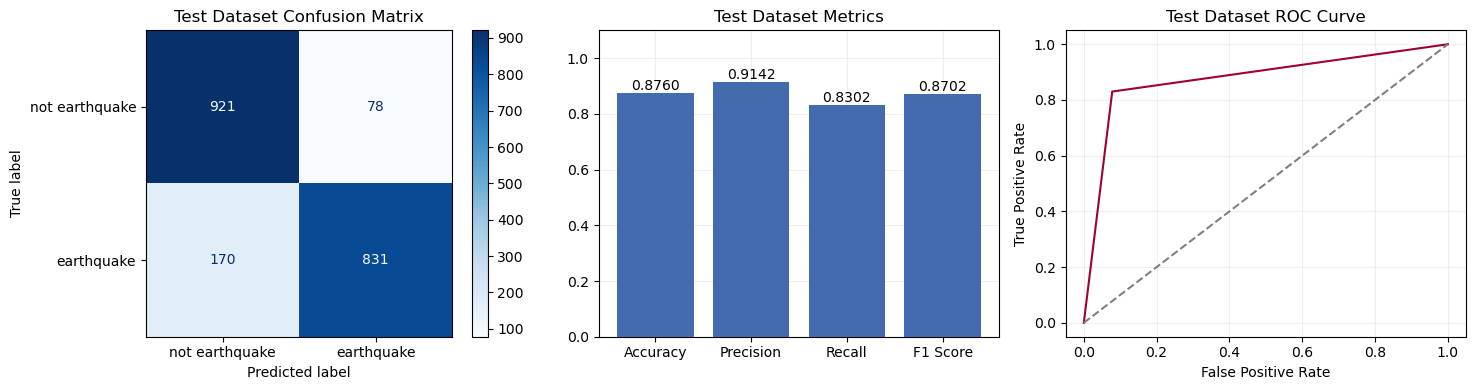

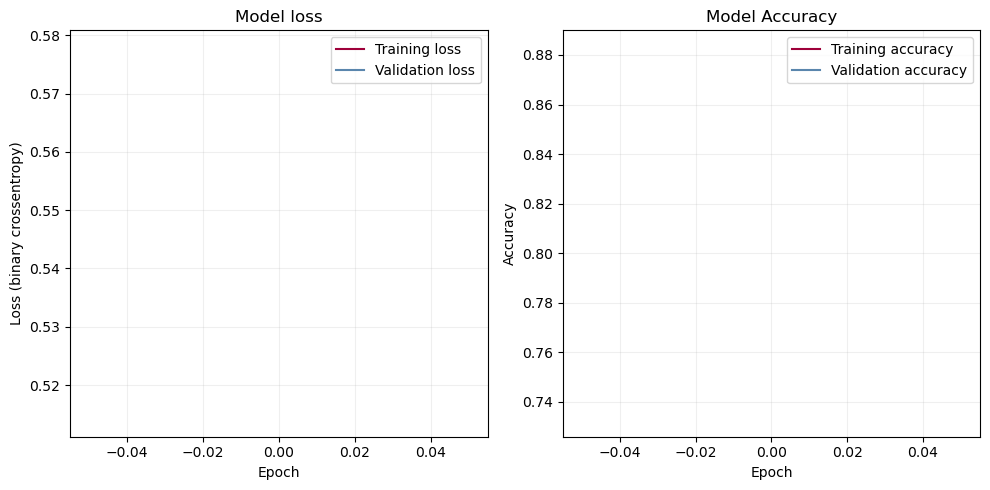

In [40]:
# Set up model callbacks
epochs = 1
callbacks_c = callbacks_setup(model_tag='cnn_classification', epochs=epochs)

# Fit model
train_dataset_c, val_dataset_c, test_dataset_c = prepare_datasets(imgs=spectrogram_imgs, labels=classifier_labels, preproc_func=image_preprocessing, preproc_func_kwargs=spectrogram_kwargs, batch_size=32)
classifier_model = build_compile_classification_cnn(learning_rate=1e-6, loss='binary_crossentropy', metrics=['accuracy'])
classifier_history = classifier_model.fit(train_dataset_c, epochs=epochs, callbacks=callbacks_c, validation_data=val_dataset_c)

# Evaluate model and plot results
evaluate_classification_model(classifier_model, test_dataset_c)
plot_training_history(classifier_history)

2025-01-23 13:54:23.821632: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Evaluating model on test dataset
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step
Model accuracy: 0.4625
 Model precision: 0.06976744186046512
 Model recall: 0.005994005994005994
 Model F1 score: 0.011039558417663294
Building confusion matrix


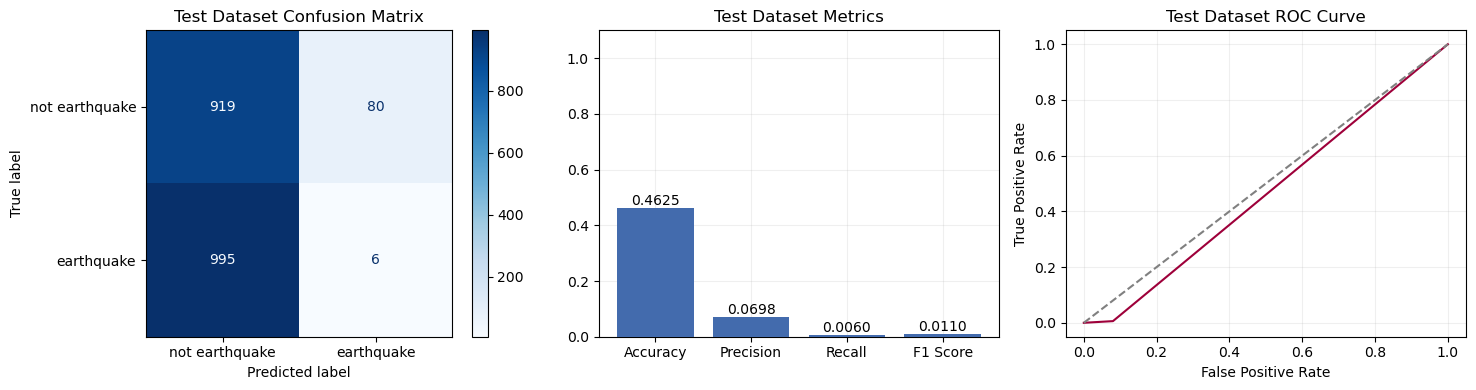

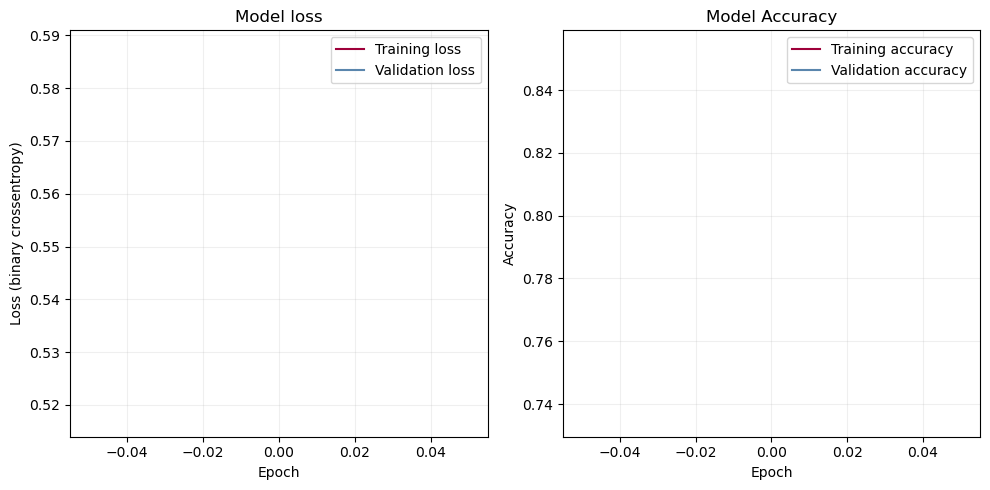

In [39]:
evaluate_classification_model(classifier_model, test_dataset_c)
plot_training_history(classifier_history)

In [410]:
def build_compile_regression_cnn(learning_rate=1e-5, loss='mse', metrics=['mae']):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, kernel_size=(5, 5), activation = 'relu', padding = 'same'),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Dropout(0.50),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss=loss, metrics=metrics)
    return model

Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - loss: 1.1771 - mae: 0.7920 - val_loss: 0.5072 - val_mae: 0.5209 - learning_rate: 1.0000e-05
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - loss: 0.5321 - mae: 0.5375 - val_loss: 0.3830 - val_mae: 0.4432 - learning_rate: 1.0000e-05
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - loss: 0.4221 - mae: 0.4737 - val_loss: 0.3590 - val_mae: 0.4211 - learning_rate: 1.0000e-05
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - loss: 0.3681 - mae: 0.4432 - val_loss: 0.3378 - val_mae: 0.4118 - learning_rate: 1.0000e-05
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - loss: 0.3537 - mae: 0.4239 - val_loss: 0.3210 - val_mae: 0.3995 - learning_rate: 1.0000e-05
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - loss: 0.3253 - mae: 0.4047 - val_loss: 0.3203 - val_mae: 0.4029 - learning_rate: 1.0000e-05
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - loss: 0.3132 - mae: 0.4064 - val_loss: 0.2994 - val_mae: 0.3872 - learning_rate: 1.

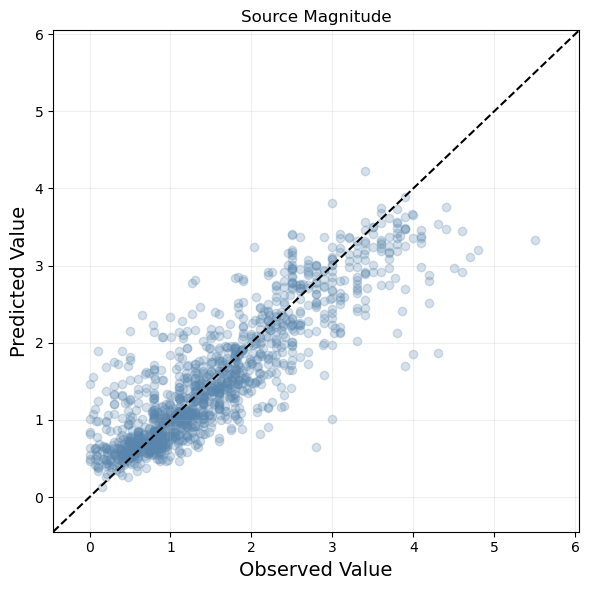

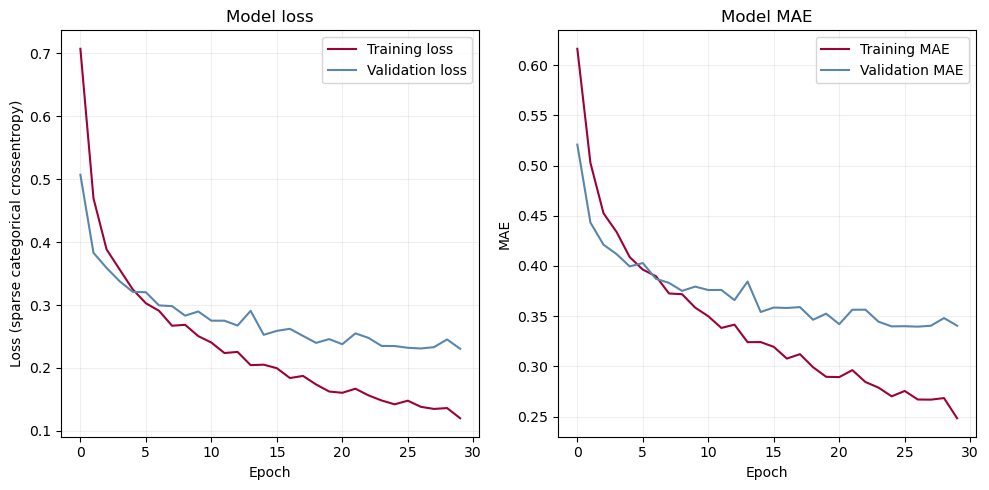

In [414]:
epochs = 20
callbacks_mag = callbacks_setup(model_tag='cnn_regression_magnitude', epochs=epochs)

labels = np.array(metadata_earthquakes_only['source_magnitude'])
train_dataset_mag, val_dataset_mag, test_dataset_mag = prepare_datasets(imgs=spectrogram_imgs_earthquakes_only, labels=labels, preproc_func=image_preprocessing, preproc_func_kwargs=spectrogram_kwargs, use_scaler=False, batch_size=64)
model_magnitude = build_compile_regression_cnn(learning_rate=1e-5, loss='mse', metrics=['mae'])
model_magnitude_history = model_magnitude.fit(train_dataset_mag, epochs=epochs, callbacks=callbacks_mag, validation_data=val_dataset_mag)

evaluate_regression_model(model_magnitude, test_dataset_mag, 'Source Magnitude', scaler=None)
plot_training_history(model_magnitude_history)

Epoch 1/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - loss: 332470.4688 - mae: 535.9275 - val_loss: 49595.4609 - val_mae: 184.2937 - learning_rate: 1.0000e-05
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - loss: 39046.6719 - mae: 164.1450 - val_loss: 31337.9082 - val_mae: 151.3778 - learning_rate: 1.0000e-05
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - loss: 32210.9434 - mae: 155.5938 - val_loss: 30824.9180 - val_mae: 150.2092 - learning_rate: 1.0000e-05
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - loss: 31599.4766 - mae: 153.8273 - val_loss: 30165.0859 - val_mae: 148.6689 - learning_rate: 1.0000e-05
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - loss: 30019.5723 - mae: 150.0141 - val_loss: 29371.3828 - val_mae: 146.5681 - learning_rate: 1.0000e-05
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - loss: 30135.7402 - mae: 149.4931 - val_loss: 28331.7070 - val_mae: 144.1888 - learning_rate: 1.0000e-05
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - loss

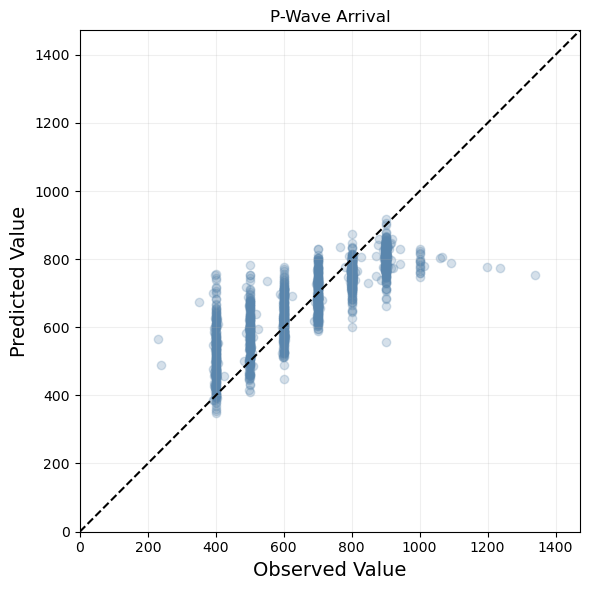

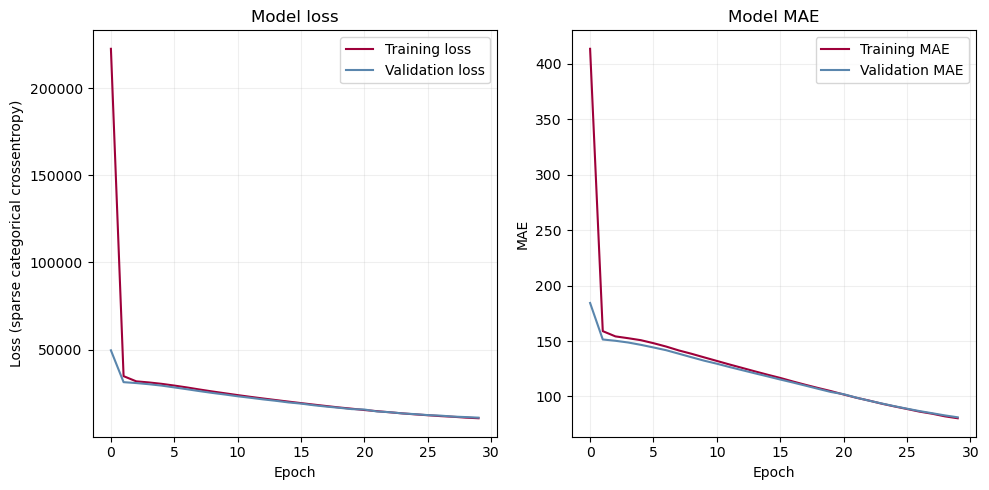

In [415]:
# Set up model callbacks
epochs = 20
callbacks_pwave = callbacks_setup(model_tag='cnn_regression_pwave', epochs=epochs)

# Fit model
labels = np.array(metadata_earthquakes_only['p_arrival_sample'])
train_dataset_pwave, val_dataset_pwave, test_dataset_pwave = prepare_datasets(imgs=waveform_imgs_earthquakes_only, labels=labels, preproc_func=image_preprocessing, preproc_func_kwargs=waveform_kwargs, use_scaler=False, batch_size=32)
model_pwave = build_compile_regression_cnn(learning_rate=1e-5, loss='mse', metrics=['mae'])
model_pwave_history = model_pwave.fit(train_dataset_pwave, epochs=epochs, callbacks=callbacks_pwave, validation_data=val_dataset_pwave)

# Evaluate model
evaluate_regression_model(model_pwave, test_dataset_pwave, 'P-Wave Arrival', scaler=None)
plot_training_history(model_pwave_history)

Epoch 1/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - loss: 1813273.3750 - mae: 1164.1664 - val_loss: 629525.3125 - val_mae: 541.3311 - learning_rate: 1.0000e-05
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - loss: 477772.8750 - mae: 494.2708 - val_loss: 412479.6562 - val_mae: 465.5491 - learning_rate: 1.0000e-05
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - loss: 401147.2812 - mae: 466.1344 - val_loss: 400077.1250 - val_mae: 456.7375 - learning_rate: 1.0000e-05
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - loss: 401250.6562 - mae: 468.4142 - val_loss: 383136.5312 - val_mae: 441.7428 - learning_rate: 1.0000e-05
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - loss: 389790.3125 - mae: 452.7224 - val_loss: 365219.1875 - val_mae: 428.9440 - learning_rate: 1.0000e-05
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - loss: 364261.5000 - mae: 439.4759 - val_loss: 349144.4375 - val_mae: 416.4818 - learning_rate: 1.0000e-05
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 193s 2

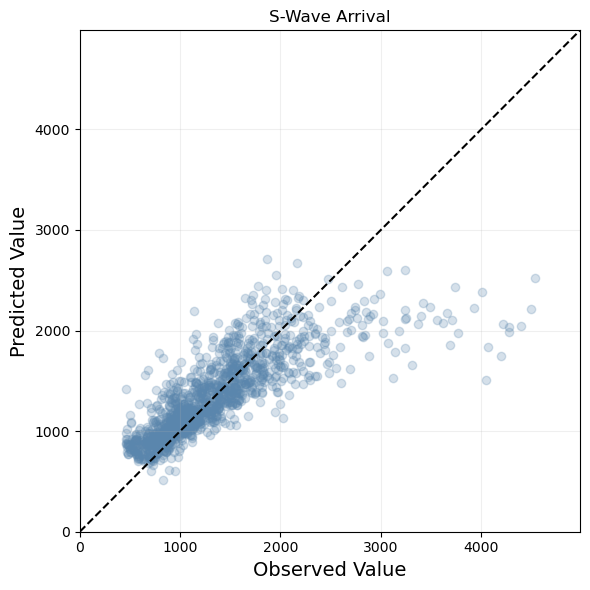

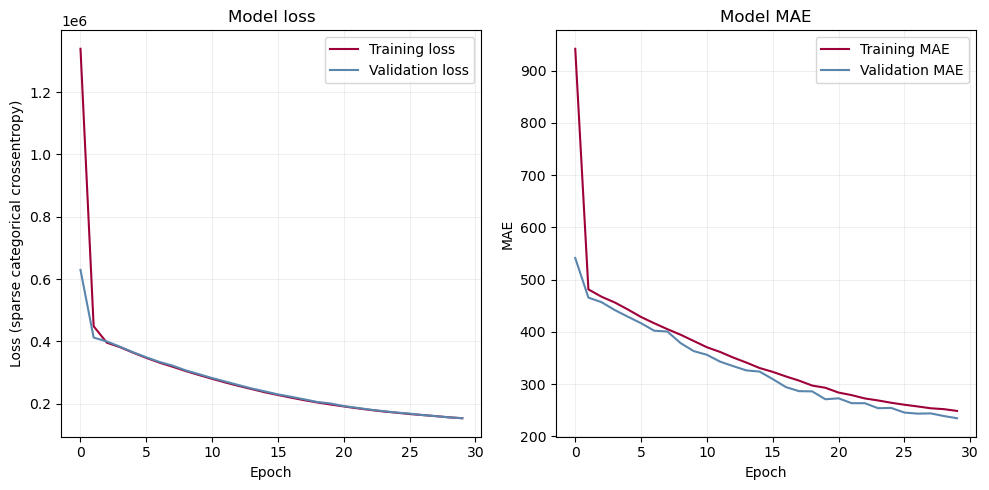

In [416]:
# Set up model callbacks
epochs = 20
callbacks_swave = callbacks_setup(model_tag='cnn_regression_swave', epochs=epochs)

# Fit model
labels = np.array(metadata_earthquakes_only['s_arrival_sample'])
train_dataset_swave, val_dataset_swave, test_dataset_swave = prepare_datasets(imgs=waveform_imgs_earthquakes_only, labels=labels, preproc_func=image_preprocessing, preproc_func_kwargs=waveform_kwargs, use_scaler=False, batch_size=32)
model_swave = build_compile_regression_cnn(learning_rate=1e-5, loss='mse', metrics=['mae'])
model_swave_history = model_swave.fit(train_dataset_swave, epochs=epochs, callbacks=callbacks_swave, validation_data=val_dataset_swave)

# Evaluate model
evaluate_regression_model(model_swave, test_dataset_swave, 'S-Wave Arrival', scaler=None)
plot_training_history(model_swave_history)

Epoch 1/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - loss: 3304.0654 - mae: 40.3183 - val_loss: 2056.2100 - val_mae: 31.1075 - learning_rate: 1.0000e-05
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - loss: 1937.4379 - mae: 30.2666 - val_loss: 1849.4733 - val_mae: 29.8749 - learning_rate: 1.0000e-05
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - loss: 1859.0924 - mae: 29.3279 - val_loss: 1790.7927 - val_mae: 29.4377 - learning_rate: 1.0000e-05
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - loss: 1731.7684 - mae: 28.1060 - val_loss: 1734.0560 - val_mae: 28.6165 - learning_rate: 1.0000e-05
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - loss: 1671.1515 - mae: 27.2651 - val_loss: 1694.5743 - val_mae: 28.1064 - learning_rate: 1.0000e-05
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - loss: 1589.1715 - mae: 26.5718 - val_loss: 1666.4286 - val_mae: 27.7581 - learning_rate: 1.0000e-05
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - loss: 1649.5319 - mae: 27.138

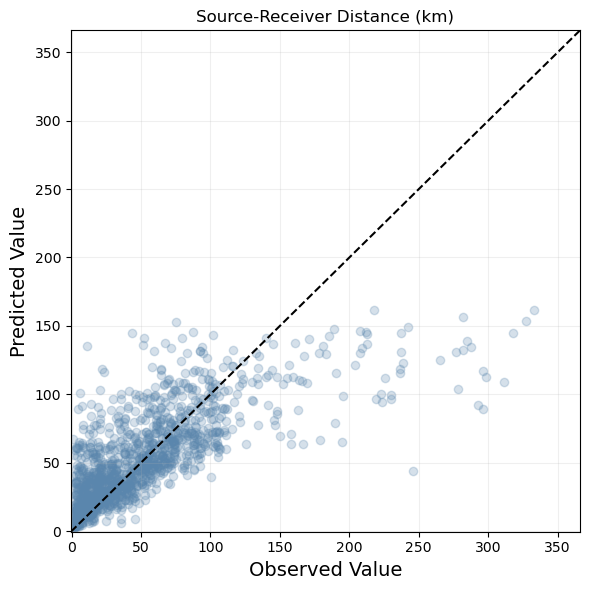

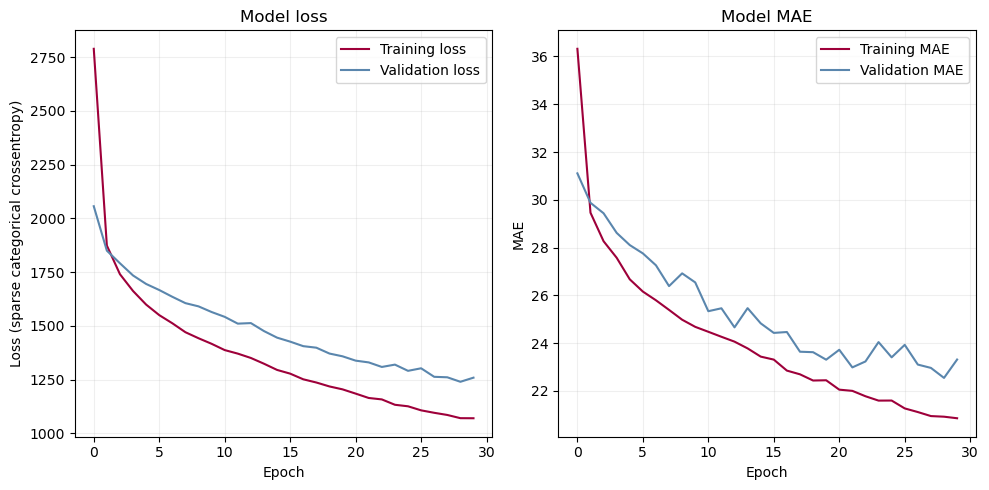

In [417]:
# Set up model callbacks
epochs = 20
callbacks_dist = callbacks_setup(model_tag='cnn_regression_distance', epochs=epochs)

# Fit model
labels = np.array(metadata_earthquakes_only['source_distance_km'])
train_dataset_dist, val_dataset_dist, test_dataset_dist = prepare_datasets(imgs=spectrogram_imgs_earthquakes_only, labels=labels, preproc_func=image_preprocessing, preproc_func_kwargs=waveform_kwargs, use_scaler=False, batch_size=32)
model_distance = build_compile_regression_cnn(learning_rate=1e-5, loss='mse', metrics=['mae'])
model_distance_history = model_distance.fit(train_dataset_dist, epochs=epochs, callbacks=callbacks_dist, validation_data=val_dataset_dist)

# Evaluate model
evaluate_regression_model(model_distance, test_dataset_dist, 'Source-Receiver Distance (km)', scaler=None)
plot_training_history(model_distance_history)

Epoch 1/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - loss: 629.6591 - mae: 13.7596 - val_loss: 475.9287 - val_mae: 13.4440 - learning_rate: 1.0000e-05
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - loss: 509.9115 - mae: 13.0865 - val_loss: 461.2321 - val_mae: 13.0853 - learning_rate: 1.0000e-05
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - loss: 500.0448 - mae: 12.8548 - val_loss: 451.8003 - val_mae: 13.2216 - learning_rate: 1.0000e-05
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - loss: 513.8826 - mae: 13.1139 - val_loss: 441.1581 - val_mae: 12.7095 - learning_rate: 1.0000e-05
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - loss: 515.2752 - mae: 12.8206 - val_loss: 434.7396 - val_mae: 12.5529 - learning_rate: 1.0000e-05
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - loss: 483.2118 - mae: 12.6643 - val_loss: 430.7126 - val_mae: 11.9189 - learning_rate: 1.0000e-05
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - loss: 426.2896 - mae: 11.7834 - val_loss:

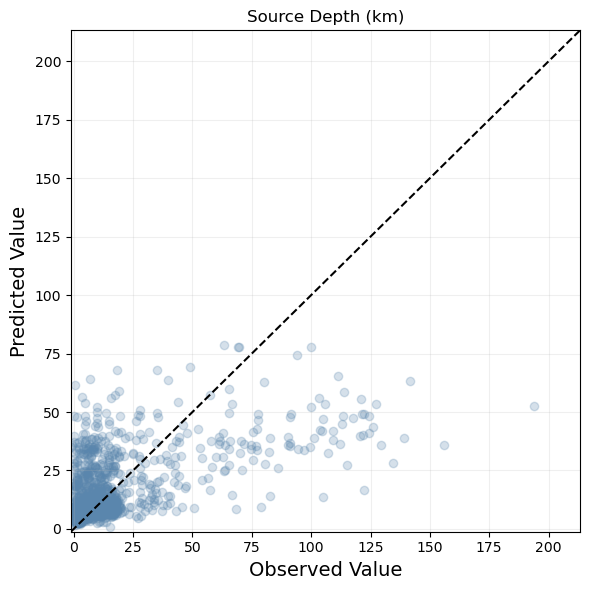

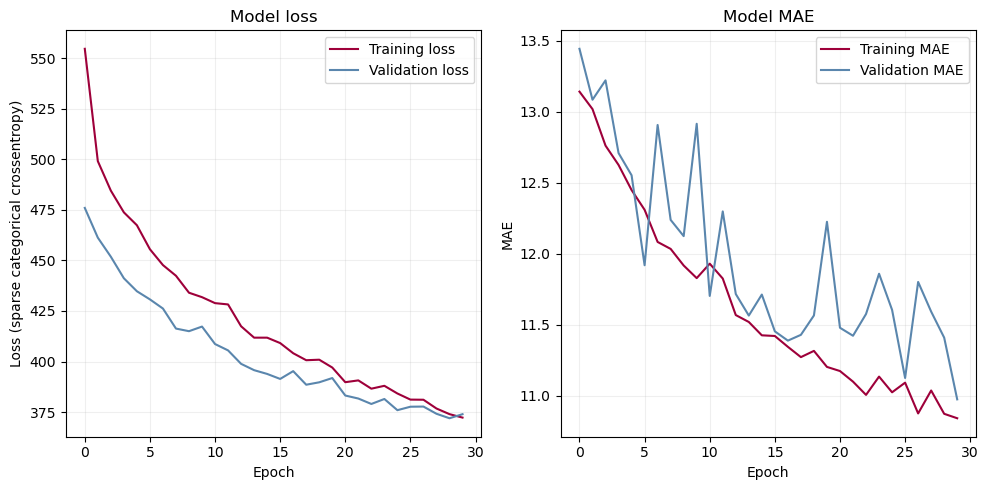

In [418]:
# Set up model callbacks
epochs = 20
callbacks_depth = callbacks_setup(model_tag='cnn_regression_depth', epochs=epochs)

# Fit model
labels = np.array(metadata_earthquakes_only['source_depth_km'])
train_dataset_depth, val_dataset_depth, test_dataset_depth = prepare_datasets(imgs=spectrogram_imgs_earthquakes_only, labels=labels, preproc_func=image_preprocessing, preproc_func_kwargs=waveform_kwargs, use_scaler=False, batch_size=32)
model_depth = build_compile_regression_cnn(learning_rate=1e-5, loss='mse', metrics=['mae'])
model_depth_history = model_depth.fit(train_dataset_depth, epochs=epochs, callbacks=callbacks_depth, validation_data=val_dataset_depth)

# Evaluate model
evaluate_regression_model(model_depth, test_dataset_depth, 'Source Depth (km)', scaler=None)
plot_training_history(model_depth_history)